## makemore: part 5

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [ ]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [ ]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [ ]:
# shuffle up the words
import random
random.seed(42)
random.shuffle(words)

In [ ]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [ ]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


- Replacement of `C[Xb]` to a embedding layer.
- .view() of Pytorch to Flatten layer.

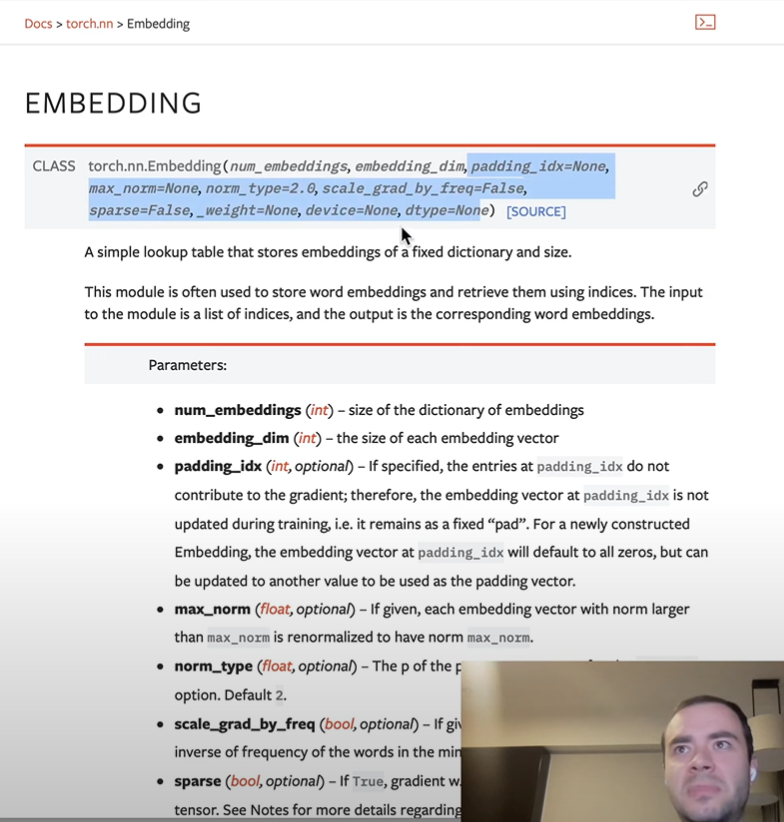

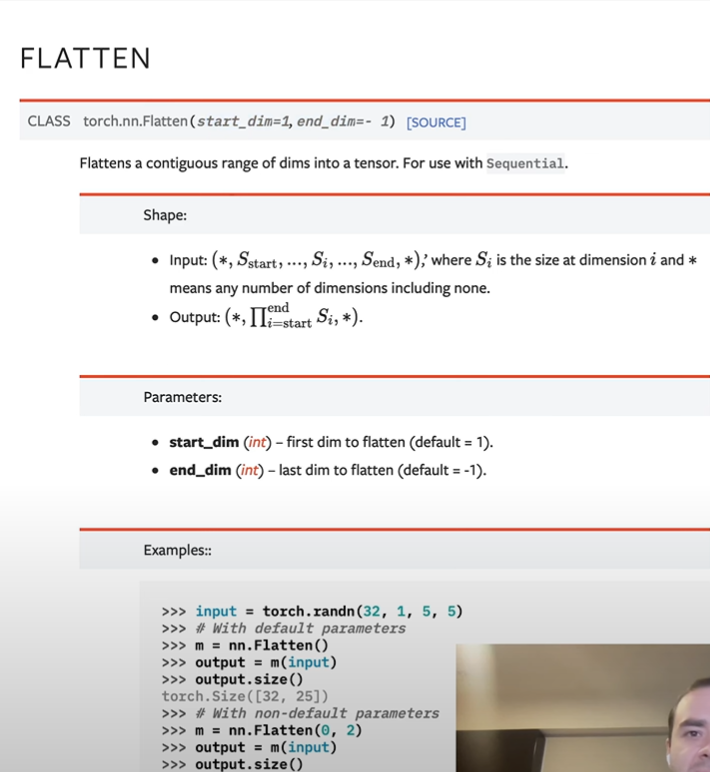

- WAY OF ORGANISING LAYERS

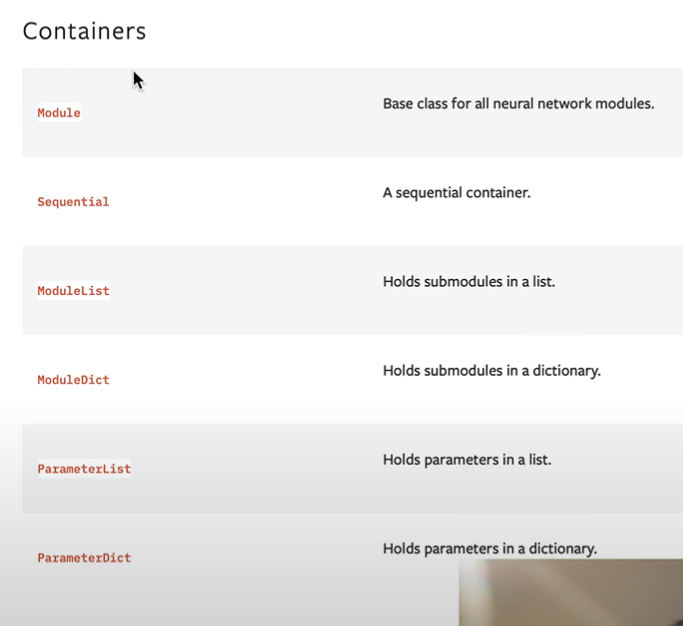

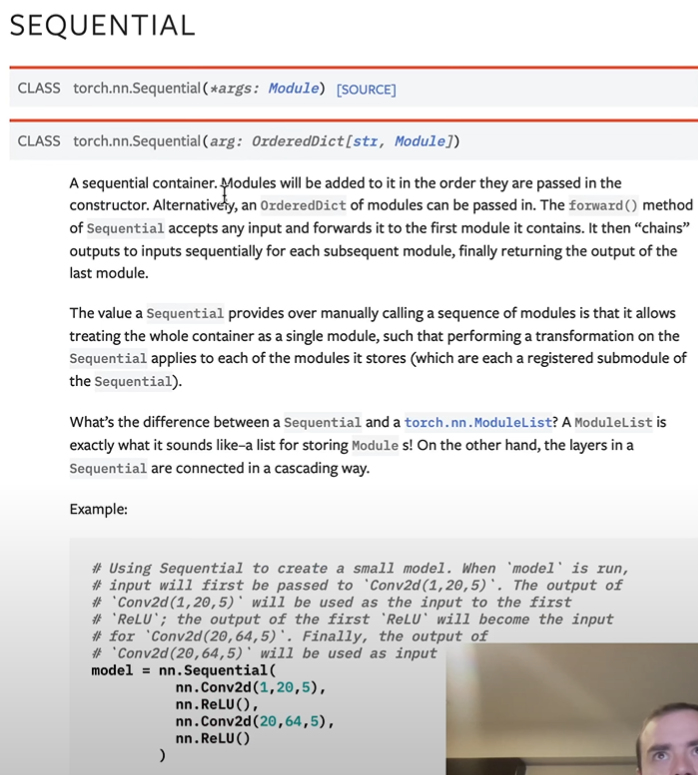

In [ ]:
# Near copy paste of the layers we have developed in Part 3

# -----------------------------------------------------------------------------------------------
class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Embedding:

  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))

  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out

  def parameters(self):
    return [self.weight]

# -----------------------------------------------------------------------------------------------
class FlattenConsecutive:

  def __init__(self, n):
    self.n = n

  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out

  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Sequential:

  def __init__(self, layers):
    self.layers = layers

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out

  def parameters(self):
    # get parameters of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]


In [ ]:
torch.manual_seed(42); # seed rng for reproducibility

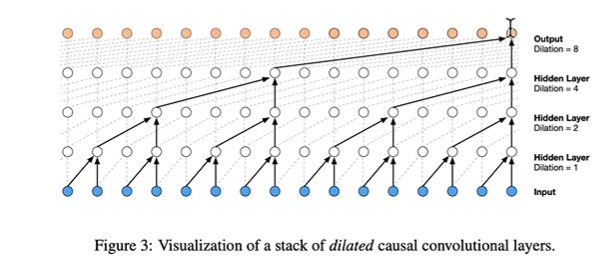

WaveNet architecture and its hierarchical, progressive fusion mechanism

### Key Concepts in WaveNet

1. **Prediction Dependency on Previous Characters**:
   - WaveNet predicts the next character in a sequence based on the previous characters.
   - Maintains a causal relationship (future characters do not influence the prediction).

2. **Hierarchical Fusion of Information**:
   - Information is not combined all at once but progressively fused in stages.
   - Characters are grouped into pairs (**bigrams**), then fused into four-character chunks, and so on.
   - This creates a **tree-like structure** for information aggregation.

3. **Dilated Causal Convolution Layers**:
   - WaveNet uses **dilated causal convolutions** to capture long-term dependencies:
     - **Dilation**: Skips input points to increase the receptive field efficiently.
     - **Causality**: Ensures future inputs do not affect the current prediction.
   - These layers are stacked to progressively handle larger context windows.

4. **Progressive Fusion**:
   - Information is aggregated in a step-by-step manner:
     - **Characters → Bigrams → Four-grams → Larger Chunks**.
   - This method ensures relationships between characters are captured at different abstraction levels.

---

### Why This Approach?

- **Deeper Contextual Understanding**:
  - Gradual fusion allows the network to better understand the relationships between characters.
- **Efficiency**:
  - Dilated convolutions and progressive fusion minimize computational costs while capturing long-term dependencies.

---

### Visualization of the Process

1. **Tree-like Structure**:
   - **Leaves**: Represent individual characters.
   - **Higher Nodes**: Represent fused chunks (bigrams, four-grams, etc.).

2. **Fusion Mechanism**:
   - At each level, adjacent elements are fused, and the resulting chunks are passed to the next level.

---

### Implementation Notes

- **Dilated Causal Convolution**:
  - Key to scalability and efficiency in WaveNet.
  - Allows the network to handle longer input sequences without excessive computational cost.

- **Progressive Fusion**:
  - Ensures information is fused slowly and meaningfully, improving prediction accuracy as the network deepens.

---

Let me know if you'd like further details or a diagram of the architecture!


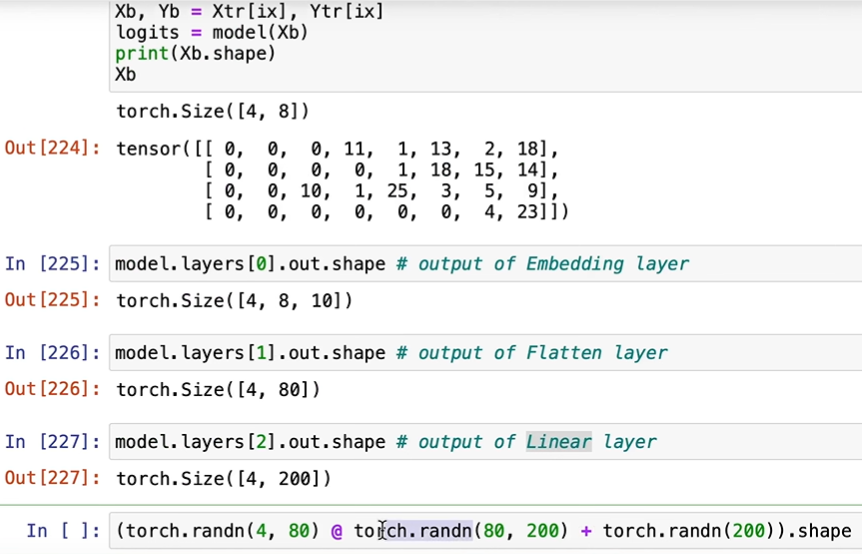

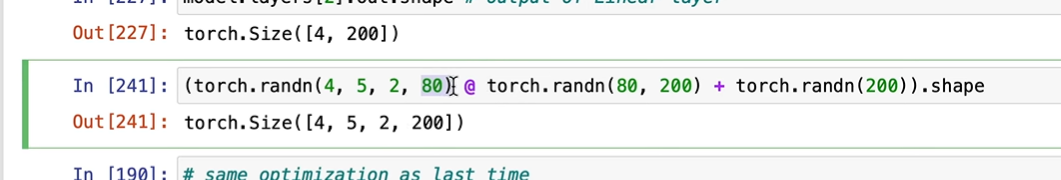

- mtuiplication happens only on the last layer from the shape

### Key Concepts in Tensor Manipulation and Matrix Multiplication

1. Broadcasting in Matrix Operations:
A tensor of shape 4x200 can broadcast with a tensor of shape 200 (a vector).
Broadcasting aligns the dimensions such that the smaller tensor is virtually "stretched" to match the larger one without additional memory usage.

2. Higher-Dimensional Tensors in Matrix Multiplication:
PyTorch's matrix multiplication (torch.matmul) supports higher-dimensional tensors.
If the input tensor has dimensions like 4x5x80:
Multiplication is applied only on the last two dimensions (80 from the input with another tensor of shape 80x200).
The output tensor shape will be 4x5x200.
The preceding dimensions (4x5 in this example) are treated as batch dimensions and processed in parallel.

### Practical Application in the Network
3. Grouping Consecutive Elements for Fusion:
Instead of flattening the input tensor directly (e.g., 4x80), consecutive elements are grouped:

Example: For 4x80, group every two elements → results in 4x4x20.
Here:
4x4 are the batch dimensions.
20 is the dimension of each group after grouping two consecutive characters.
This structure allows parallel processing of groups at multiple levels (batch dimensions and grouped elements).

### Steps to Modify the Linear and Flatten Layers
4. Goal Transformation:
Instead of feeding a 4x80 tensor into the linear layer, transform it to 4x4x20.
Update the layers:
Flatten Layer:
Reshape the output to group consecutive elements.
Transform from 4x80 → 4x4x20.
Linear Layer:
Adjust the expected input dimensions to match the grouped input (e.g., 20 instead of 80).
Perform matrix multiplication accordingly.


### Visualization of Tensor Processing
1. Initial Input: 4x80.
2. Desired Transformation: Reshape into 4x4x20:
4 (outer batch dimension).
4 (grouping dimension for pairs of elements).
20 (flattened size of each group).

3. Matrix Multiplication:
Apply matrix multiplication only on the last two dimensions (20x200).
Resulting shape: 4x4x200.


### Benefits of Grouping and Batch Dimensions
- Parallelism: Enables simultaneous processing of multiple groups across batches.

- Modularity: Allows more flexibility in the design of deeper networks by focusing on smaller groups of elements.

- Scalability: Simplifies handling of larger inputs without losing structural relationships in data.
This design ensures a progressive hierarchical fusion of input elements while leveraging the flexibility and power of PyTorch’s tensor operations. Let me know if you need example code or further clarifications!

This design ensures a progressive hierarchical fusion of input elements while leveraging the flexibility and power of PyTorch’s tensor operations

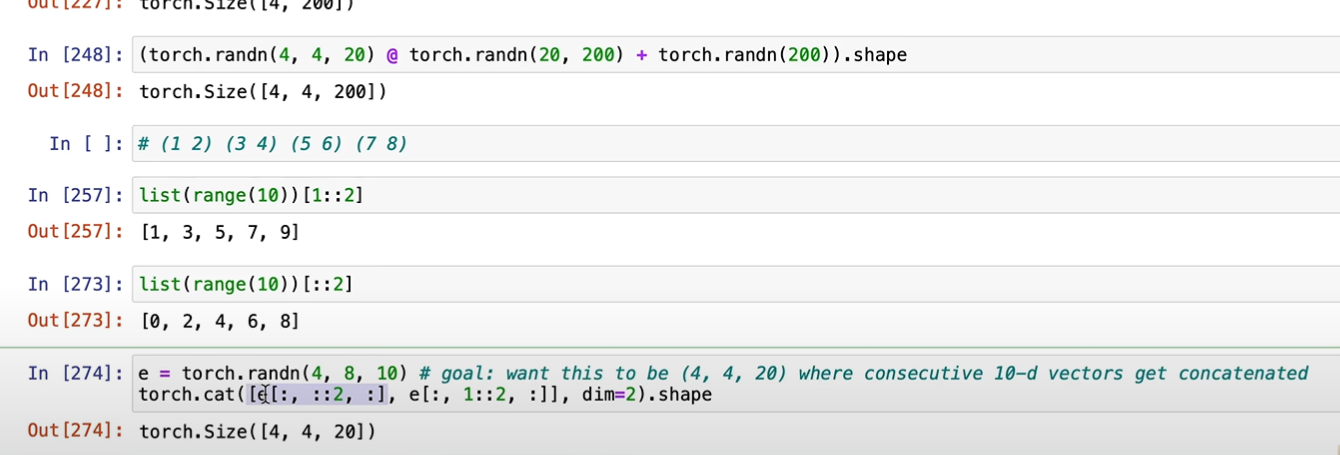

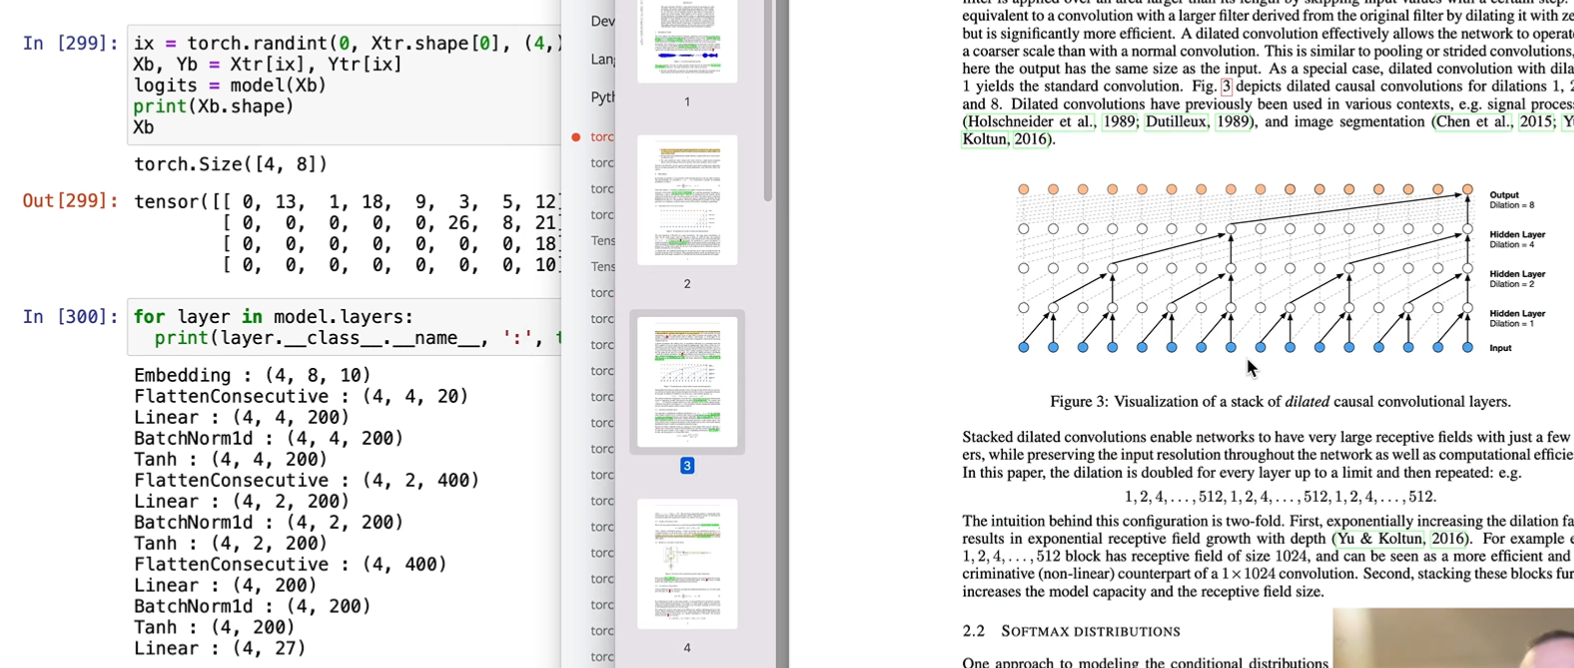

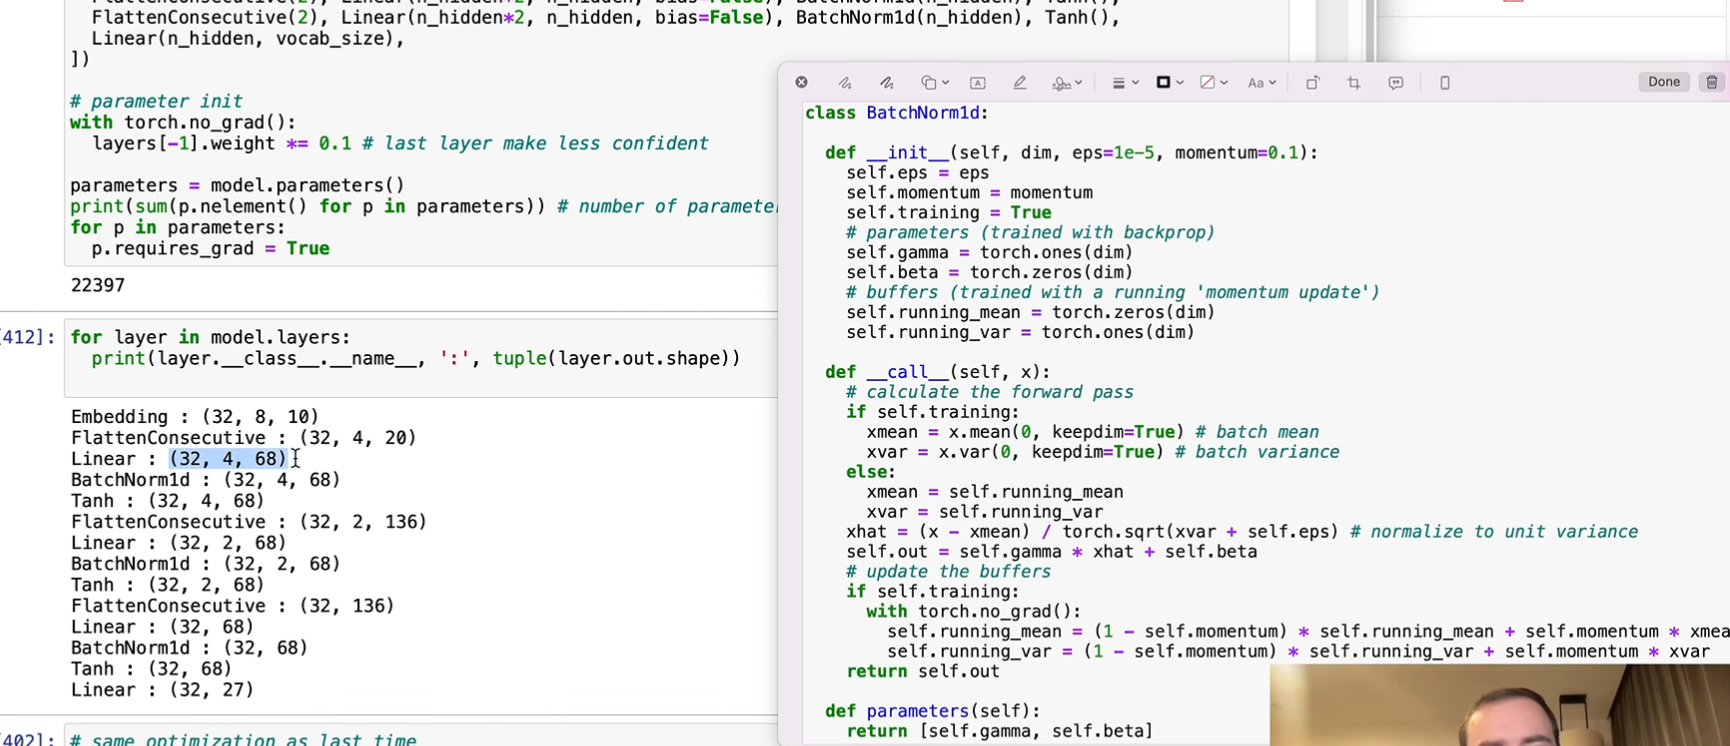

- batch norm bug bcoz of pair dimension

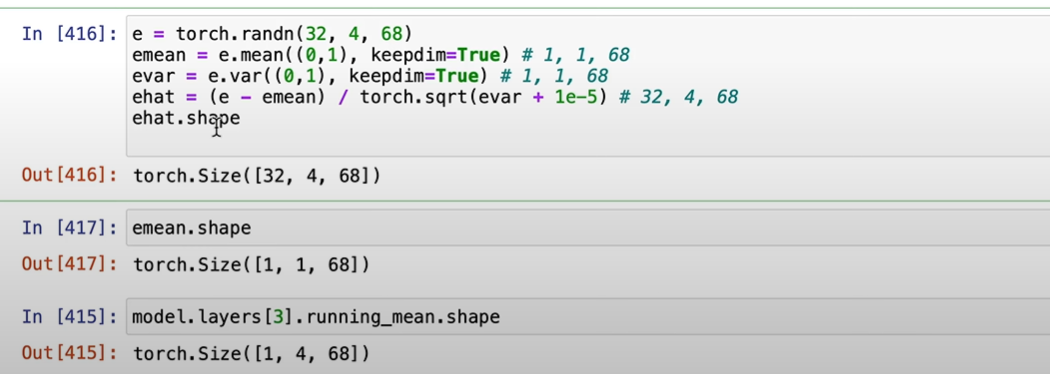

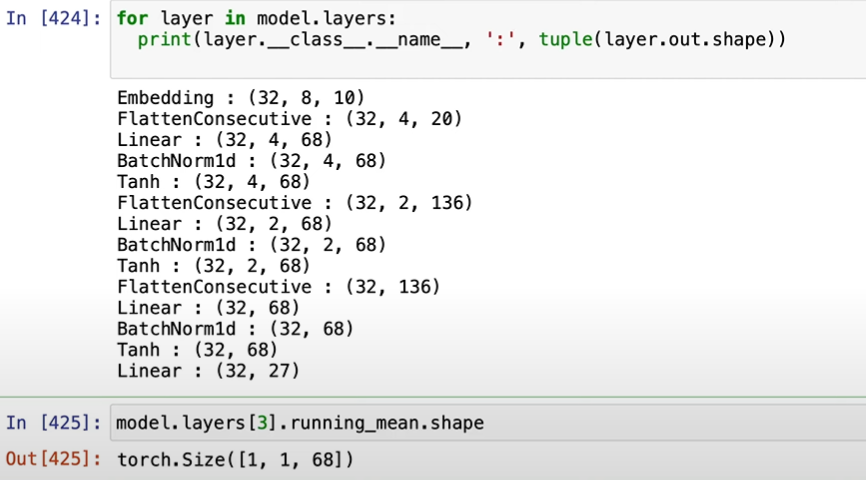

In [ ]:
# original network
# n_embd = 10 # the dimensionality of the character embedding vectors
# n_hidden = 300 # the number of neurons in the hidden layer of the MLP
# model = Sequential([
#   Embedding(vocab_size, n_embd),
#   FlattenConsecutive(8), Linear(n_embd * 8, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(n_hidden, vocab_size),
# ])

# hierarchical network
n_embd = 24 # the dimensionality of the character embedding vectors
n_hidden = 128 # the number of neurons in the hidden layer of the MLP
model = Sequential([
  Embedding(vocab_size, n_embd),
  FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
  model.layers[-1].weight *= 0.1 # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

76579


In [ ]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update: simple SGD
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())


      0/ 200000: 3.3167
  10000/ 200000: 2.0576
  20000/ 200000: 2.0723
  30000/ 200000: 2.5134
  40000/ 200000: 2.1476
  50000/ 200000: 1.7836
  60000/ 200000: 2.2592
  70000/ 200000: 1.9331
  80000/ 200000: 1.6875
  90000/ 200000: 2.0395
 100000/ 200000: 1.7736
 110000/ 200000: 1.9570
 120000/ 200000: 1.7465
 130000/ 200000: 1.8126
 140000/ 200000: 1.7406
 150000/ 200000: 1.7466
 160000/ 200000: 1.8806
 170000/ 200000: 1.6266
 180000/ 200000: 1.6476
 190000/ 200000: 1.8555


- correction performed on graph using view, [200,10000]

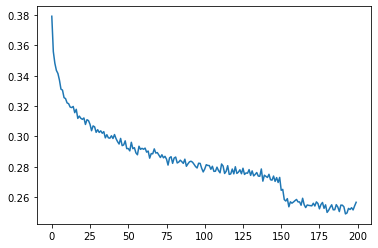

In [ ]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [ ]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
  layer.training = False

In [ ]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.7690284252166748
val 1.9936515092849731


### performance log

- original (3 character context + 200 hidden neurons, 12K params): train 2.058, val 2.105
- context: 3 -> 8 (22K params): train 1.918, val 2.027
- flat -> hierarchical (22K params): train 1.941, val 2.029
- fix bug in batchnorm: train 1.912, val 2.022
- scale up the network: n_embd 24, n_hidden 128 (76K params): train 1.769, val 1.993


In [ ]:
# sample from the model
for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break

    print(''.join(itos[i] for i in out)) # decode and print the generated word

arlij.
chetta.
heago.
rocklei.
hendrix.
jamylie.
broxin.
denish.
anslibt.
marianah.
astavia.
annayve.
aniah.
jayce.
nodiel.
remita.
niyelle.
jaylene.
aiyan.
aubreana.


### Next time:
Why convolutions? Brief preview/hint

In [ ]:
for x,y in zip(Xtr[7:15], Ytr[7:15]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .


In [ ]:
# forward a single example:
logits = model(Xtr[[7]])
logits.shape

torch.Size([1, 27])

In [ ]:
# forward all of them
logits = torch.zeros(8, 27)
for i in range(8):
  logits[i] = model(Xtr[[7+i]])
logits.shape

torch.Size([8, 27])

In [ ]:
# convolution is a "for loop"
# allows us to forward Linear layers efficiently over space

- For loop is inside cuda kernel.

# Benefits of Grouping and Batch Dimensions in Practical Examples

## 1. Key Concept: Sliding Window in Convolution
### Problem with Naive Approach
- **Sequential Processing**:
  - Using a for-loop in Python to compute outputs for each position is **inefficient**.
  - Intermediate results are **recalculated**, leading to wasted computation.
- **Limited Memory Reuse**:
  - Naive methods do not reuse intermediate results across positions.

### Solution with Convolution
- **Sliding Filters**:
  - Convolutions slide a filter (kernel) over the input sequence, efficiently computing outputs for all positions in parallel.
- **Hardware Acceleration**:
  - CUDA kernels optimize this operation, hiding the loop inside the GPU implementation.

---

## 2. Practical Implementation in PyTorch

### Naive Approach (Using For Loops)
```python
import torch
import torch.nn as nn

# Example input tensor (batch_size=1, sequence_length=8, channels=1)
sequence = torch.randn(1, 1, 8)

# Define a linear filter
linear_filter = nn.Linear(2, 1)

# Naive computation with a for-loop
logits = []
for i in range(sequence.shape[2] - 1):  # Sliding 2-element window
    window = sequence[:, :, i:i+2]  # Extract 2-element window
    logits.append(linear_filter(window.view(1, -1)))  # Linear filter

# Combine results
output_naive = torch.cat(logits, dim=0)
print("Naive Approach Output Shape:", output_naive.shape)
# Output: Naive Approach Output Shape: torch.Size([7, 1])
```
### Efficient Approach (Using Convolutions)
```python
# Define a convolutional layer with kernel size 2
conv = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=2, stride=1, bias=True)

# Efficient computation using convolution
output_conv = conv(sequence)
print("Convolution Output Shape:", output_conv.shape)
# Output: Convolution Output Shape: torch.Size([1, 1, 7])
```


Key Difference:

- The convolutional approach computes all outputs in a single call, reusing intermediate results and leveraging GPU hardware.
- The naive approach computes outputs one by one, recalculating intermediate nodes and requiring more overhead.


## 3. Memory Reuse with Convolution
Convolutions reuse intermediate results for efficiency:

- Reusability in Filters:
    - Each node in the computation tree (e.g., the value of a child node) is reused in multiple calculations.
    - In a CNN, these filters (linear layers) slide over the input, leveraging the same computations for overlapping regions.
- Practical Example of Reuse:
  - The same filter weights are applied across the sequence, avoiding recomputation of shared regions.

## 4. Benefits in a Practical Setting
### Efficiency:
- GPU-optimized operations reduce computation time compared to Python loops.
- Avoids recalculating intermediate results.
### Scalability:
- Handles large sequences without a performance bottleneck.
### Parallelism:
- Filters are applied across multiple positions and batches simultaneously.
### Flexibility:
- Easily adjusts for input size, stride, and kernel size to suit different sequence-processing tasks.

## 5. Full Example: Sliding a Filter Over a Sequence
Here’s how a convolutional layer can replace a loop entirely:

```python
class SequenceModel(nn.Module):
    def __init__(self, kernel_size=2, in_channels=1, out_channels=1):
        super(SequenceModel, self).__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size)

    def forward(self, x):
        return self.conv(x)

# Instantiate model
model = SequenceModel(kernel_size=2)

# Input tensor (batch_size=1, in_channels=1, sequence_length=8)
input_sequence = torch.randn(1, 1, 8)

# Forward pass
output = model(input_sequence)
print("Model Output Shape:", output.shape)
# Output: torch.Size([1, 1, 7])
```
This implementation demonstrates how convolution layers enhance efficiency, scalability, and memory reuse in sequence processing tasks.